# IDENTIFY THE DANCE FORM

**Identify the dance form is a machine learning competition hosted by hackerearth: a platform where you can learn coding and machine learning. I'll use the dataset of this competition for my course project 'Deep Learning with Pytorch: Zero to GANs' : a free course provided by jovian.ml and freecode camp. For more information visit.** 

## Problem statement

This International Dance Day, an event management company organized an evening of Indian classical dance performances to celebrate the rich, eloquent, and elegant art of dance. Post the event, the company planned to create a microsite to promote and raise awareness among the public about these dance forms. However, identifying them from images is a tough nut to crack.

You have been appointed as a Machine Learning Engineer for this project. Build an image tagging Deep Learning model that can help the company classify these images into eight categories of Indian classical dance.

**The dataset consists of 364 images belonging to 8 categories, namely manipuri, bharatanatyam, odissi, kathakali, kathak, sattriya, kuchipudi, and mohiniyattam.**

Dataset link : https://www.hackerearth.com/challenges/competitive/hackerearth-deep-learning-challenge-identify-dance-form/

**In this notebook I will usedifferent artchiture given below and measure their effectiveness:**
1. Use feedword neural network
2. Transfer learning

# Importing the libraries

In [1]:
!pip install fastai2

     |████████████████████████████████| 190 kB 6.5 MB/s eta 0:00:01


In [2]:
from fastai2.vision.all import *
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [3]:
project_name = 'Dance-Classifier'

# Exploring The Dataset

In [4]:
DATA_DIR = '../input/indian-danceform-classification/dataset'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV =  DATA_DIR + '/test.csv'                        # Contains dummy labels for test image

All the given training images are at TRAIN_DIR directory. Let's look at few: 

In [5]:
os.listdir(TRAIN_DIR)[:5]

['322.jpg', '234.jpg', '260.jpg', '66.jpg', '294.jpg']

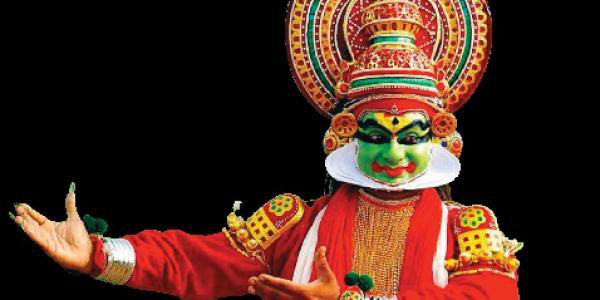

In [6]:
Image.open(TRAIN_DIR+'/234.jpg')

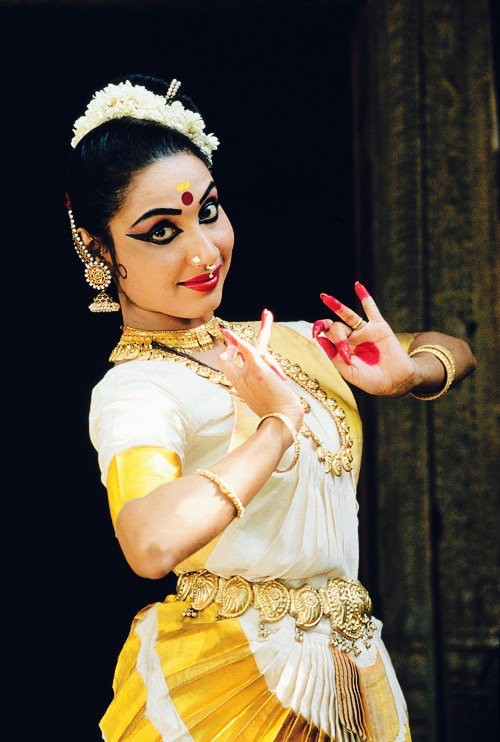

In [7]:
Image.open(TRAIN_DIR+'/287.jpg')

**Q: What is the total no of images?**

In [8]:
len(os.listdir(TRAIN_DIR))

364

**To train a classifier we need labels which is given in TRAIN_CSV file. Each images is mapped with their labels in this file. Let's look at this file.**

In [9]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


**Q: what is the total no of images belongs to each class?**

In [10]:
train_df.target.value_counts()

mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

# Dataset and Dataloader

I will use fastai datablock to make dataset and dataloader which I've learn recently through fastbook. If you want to learn Machine Learning this is the best resourse. Visit [fast.ai](http://fast.ai) for more information.

In [11]:
def get_x(r): return DATA_DIR+'/train/'+r['Image']  # Image Directory
def get_y(r): return r['target']                    # Getting the label
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    splitter=RandomSplitter(),
    get_x = get_x,
    get_y = get_y,
    item_tfms = Resize(330),
    batch_tfms=aug_transforms(mult=2))

dls = dblock.dataloaders(train_df)

train_dl = dls.train
valid_dl = dls.valid

**Let's look a batch of dataset**

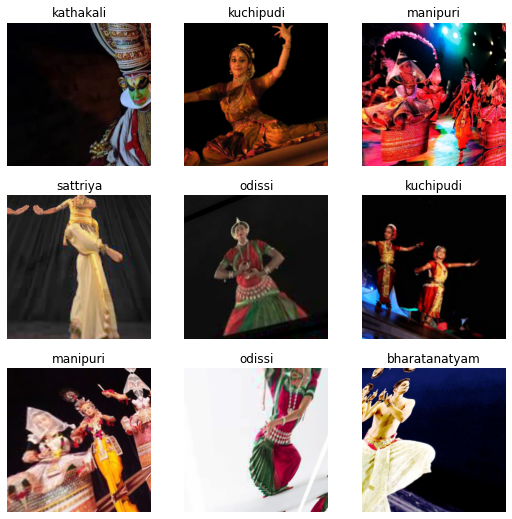

In [12]:
dls.show_batch()

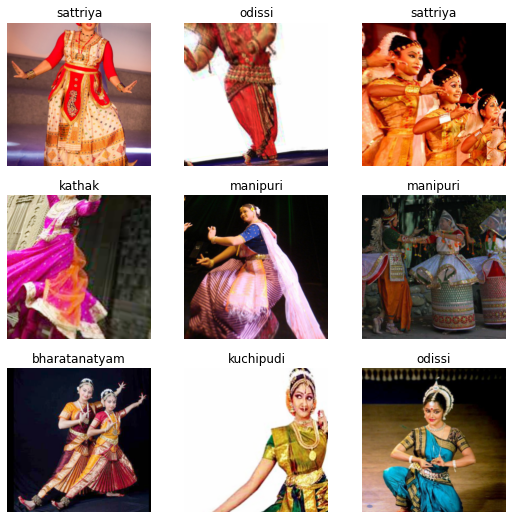

In [13]:
dls.train.show_batch()

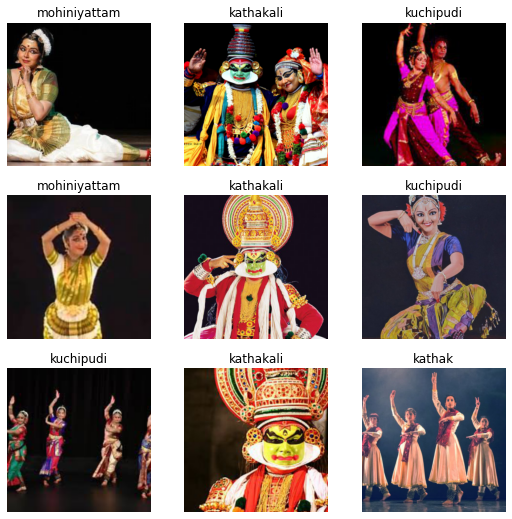

In [14]:
dls.valid.show_batch()

In [ ]:
# Let's save the work to jovian
!pip install jovian --upgrade -q
import jovian
jovian.commit(project = project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sonujha092/Dance-Classifier


<IPython.core.display.Javascript object>

# Model
Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the __init__ and __forward__ methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [17]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# 1. Feedforward Network

In [18]:
class DanceModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)  # first linear layer
        self.linear2 = nn.Linear(512, 128)          # second linear layer
        self.linear3 = nn.Linear(128, output_size)  # third linear layer

        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
        return out

# Model on GPU

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
device = get_default_device()
print(device)

# image size is 224x224x3 
# output class = 8
input_size = 330*330*3
output_size = 8
model = to_device(DanceModel(), device)

cuda


Before you train the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.087515354156494, 'val_acc': 0.1015625}]

**Train the model using the fit function to reduce the validation loss & improve accuracy.**

In [24]:
history += fit(5, 1e-3, model, train_dl, valid_dl)

Epoch [0], val_loss: 2.0950, val_acc: 0.1016
Epoch [1], val_loss: 2.0925, val_acc: 0.0938
Epoch [2], val_loss: 2.0950, val_acc: 0.0703
Epoch [3], val_loss: 2.0998, val_acc: 0.0703
Epoch [4], val_loss: 2.0927, val_acc: 0.0703


In [25]:
history += fit(5, 1e-2, model, train_dl, valid_dl)

Epoch [0], val_loss: 2.0632, val_acc: 0.0703
Epoch [1], val_loss: 2.0651, val_acc: 0.3203
Epoch [2], val_loss: 2.0688, val_acc: 0.0859
Epoch [3], val_loss: 2.0781, val_acc: 0.0859
Epoch [4], val_loss: 2.0828, val_acc: 0.0781


**Let us also define a couple of helper functions for plotting the losses & accuracies.**

In [26]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

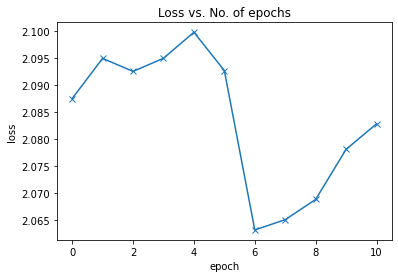

In [27]:
plot_losses(history)

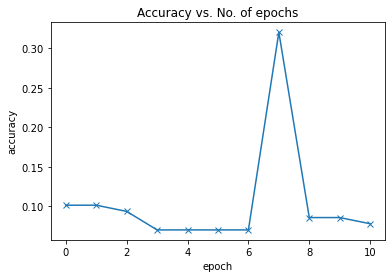

In [28]:
plot_accuracies(history)

## Recoding your results

As we perform multiple experiments, it's important to record the results in a systematic fashion, so that we can review them later and identify the best approaches that we might want to reproduce or build upon later. 

**list of artchitures**

In [29]:
arch1 = "4 layers (1024, 512, 128, 8)"
arch2 = '3 layers (512, 128, 8)'
arch = [arch1, arch2]

**List of learning rates**

In [30]:
lrs1 = [1e-2, 1e-3]
lrs2 = [1e-2, 1e-3]
lrs = [lrs1, lrs2]

**No of epoch used while training**

In [31]:
epoch1 = [5, 5]
epoch2 = [5, 5]
epochs = [epoch1, epoch2]

**Final validation accuracy and loss**

In [32]:
valid_acc = [14.8, 24]
valid_loss = [2.10, 2.10]

In [33]:
torch.save(model.state_dict(), 'dance-feed-forward.pth')

In [34]:
# Clear previously recorded hyperparams & metrics
jovian.reset()

In [35]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)

[jovian] Hyperparams logged.


In [36]:
jovian.log_metrics(valid_loss=valid_loss, valid_acc=valid_acc)

[jovian] Metrics logged.


In [37]:
jovian.commit(project=project_name, outputs=['dance-feed-forward.pth'], environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sonujha092/Dance-Classifier


<IPython.core.display.Javascript object>

# 2. Transfer Learning

In [38]:
class DanceResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
#         self.network = models.resnet34(pretrained=True)
        self.network = models.resnet50(pretrained=True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

# Training

In [39]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model on GPU

In [40]:
device = get_default_device()
print(device)
model = to_device(DanceResnet(), device)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


**Train the model using the fit function to reduce the validation loss & improve accuracy.**

In [41]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.317747116088867, 'val_acc': 0.03125}]

In [42]:
model.freeze()

In [43]:
epochs = 5
max_lr =  1e-3
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [44]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 2.1485, val_acc: 0.3047



Epoch [1], val_loss: 2.1489, val_acc: 0.2422



Epoch [2], val_loss: 2.0600, val_acc: 0.3672



Epoch [3], val_loss: 1.8229, val_acc: 0.6953



Epoch [4], val_loss: 1.7422, val_acc: 0.7734
CPU times: user 8.36 s, sys: 5.79 s, total: 14.1 s
Wall time: 40 s


In [45]:
model.unfreeze()

In [46]:
%%time
history += fit_one_cycle(5, 1e-4, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], val_loss: 1.6870, val_acc: 0.6953



Epoch [1], val_loss: 1.6645, val_acc: 0.7969



Epoch [2], val_loss: 1.6827, val_acc: 0.8125



Epoch [3], val_loss: 1.6648, val_acc: 0.7969



Epoch [4], val_loss: 1.6615, val_acc: 0.7969
CPU times: user 8.4 s, sys: 5.84 s, total: 14.2 s
Wall time: 40.6 s


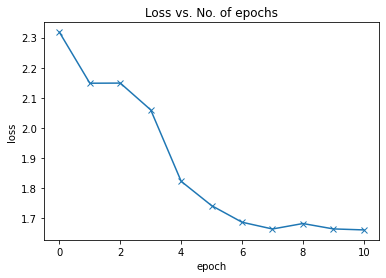

In [47]:
plot_losses(history)

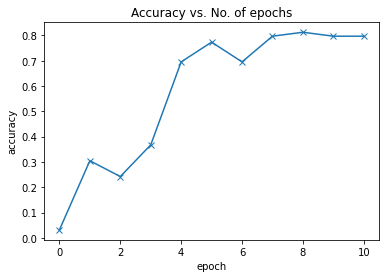

In [48]:
plot_accuracies(history)

## Recoding your results

As we perform multiple experiments, it's important to record the results in a systematic fashion, so that we can review them later and identify the best approaches that we might want to reproduce or build upon later. 

**list of artchitures**

In [49]:
arch1 = 'resnet 34'
arch2 = 'resnet 50'
arch3 = 'resnet 50: replaced RandomResized224 to Resize224'
arch3 = 'resnet 50: replaced Resized224 to Resize330'
arch = [arch1, arch2, arch3]

**List of learning rates**

In [50]:
lrs1 = [1e-4, 1e-4]
lrs2 = [1e-3, 1e-4]
lrs = [lrs1, lrs2]

**No of epoch used while training**

In [51]:
epoch1 = [5, 5]
epoch2 = [5, 5]
epochs = [epoch1, epoch2]

**Final validation accuracy and loss**

In [52]:
valid_acc = [64, 71]
valid_loss = [1.76, 1.68]

In [53]:
torch.save(model.state_dict(), 'dance-resnet50.pth')

In [54]:
# Clear previously recorded hyperparams & metrics
jovian.reset()

In [55]:
jovian.log_hyperparams(arch=arch, 
                       lrs=lrs, 
                       epochs=epochs)

[jovian] Hyperparams logged.


In [56]:
jovian.log_metrics(valid_loss=valid_loss, valid_acc=valid_acc)

[jovian] Metrics logged.


In [57]:
jovian.commit(project=project_name, outputs=['dance-resnet50.pth'], environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sonujha092/Dance-Classifier


<IPython.core.display.Javascript object>